In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os
import scipy as scp
import scipy.signal as sgn

plt.style.use('fast')
#plt.rc('text', usetex=True)


In [2]:
filepaths = ['..\XRD']
measurements = {}
for filepath in filepaths:
    for name in os.listdir(filepath):
        if name.endswith('.xlsx'):
            df = pd.read_excel(filepath + '\\' + name)
            arr = np.transpose(df.to_numpy())
            measurements[name.split('.')[0]] = arr

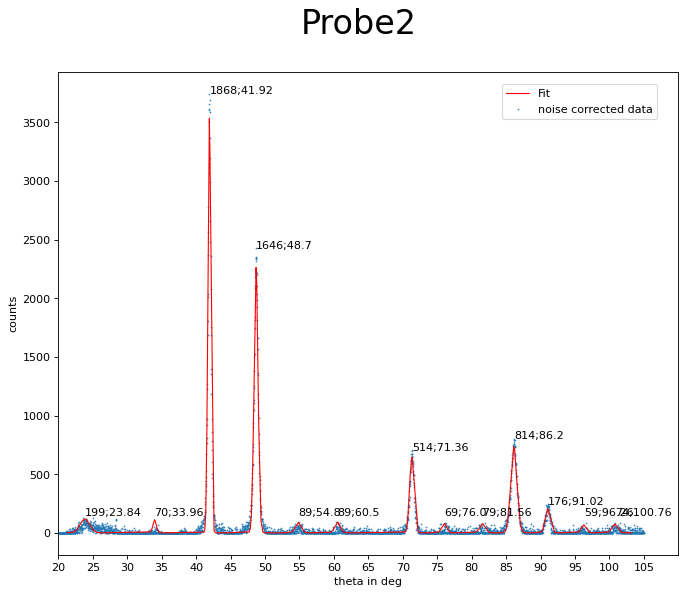

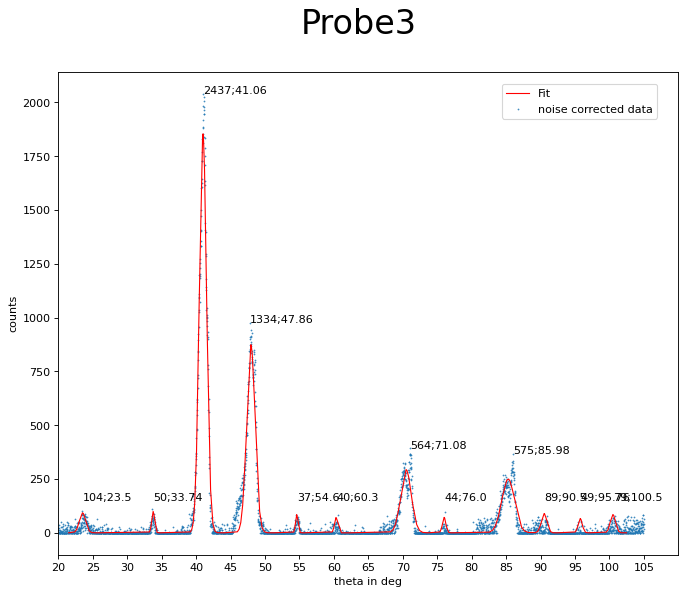

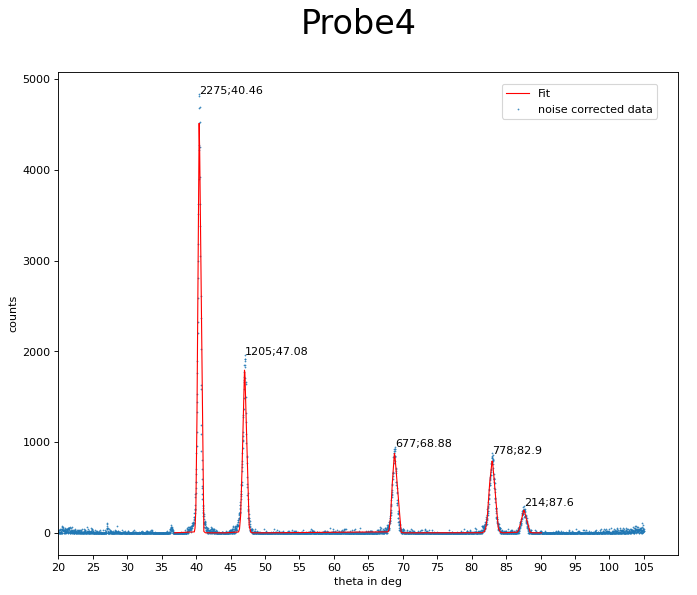

In [84]:
def f(x,a,b,c,d,e,f):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

def f2(x,a,b):
    return a + b*x

def clean(x,y):
    med = np.average(arr)
    x_n = []
    y_n = []
    for i,v in enumerate(y):
        if v < 3*med:
            x_n.append(x[i])
            y_n.append(v)
    return x_n,y_n

def clean2(x,y):
    med = np.average(arr)
    x_n = []
    y_n = []
    for i,v in enumerate(y):
        if v < 100:
            x_n.append(x[i])
            y_n.append(v)
    return x_n,y_n

def remove_noise(data,noise):
    clean = []
    for i,e in enumerate(data):
        if e > noise[i]:
            clean.append(e-noise[i])
        else:
            clean.append(0)
    return clean       

def gauss(x,A,w,xc):
    return 0 + A/(w*np.sqrt(np.pi/2)) *np.exp(-2*((x-xc)/w)**2)

def sort(arr,arr_d):
    c = True

    while c:
        c = False
        #print(len(arr))
        for i,e in enumerate(arr):
            if i == len(arr)-1:
                break 
            if arr[i+1] < e:
                c = True
                arr[i] = arr[i+1]
                arr[i+1] = e
                t = arr_d[i]
                arr_d[i] = arr_d[i+1]
                arr_d[i+1] = t
    return arr,arr_d 

for name in measurements:
    intensity = measurements[name][-1]
    theta = measurements[name][0]

    fit_x = []
    fit_y = []

    peak_s = []
    int_s = []


    fig = plt.figure(figsize=(10,8),dpi=80)
    fig.tight_layout(pad=0.5, w_pad=3.5, h_pad=3.5)
    fig.suptitle(name,size=30)
    
    ax = fig.add_subplot(111)
    #ax.scatter(theta,intensity,marker=".",s=1)
    #peaks, properties = sgn.find_peaks(intensity, prominence=0.0001, width=20)
    #ax.scatter(theta[peaks],intensity[peaks],marker="o")

    x,y = clean(theta,intensity)
    popt, pcov = scp.optimize.curve_fit(f,x,y)
    intensity_new = remove_noise(intensity,[f(x,*popt) for x in theta])
    #ax.plot(theta,[f(x,*popt) for x in theta],color='purple')
    
    ax.scatter(theta,intensity_new,marker=".",s=1,label="noise corrected data")
    
    peaks, properties = sgn.find_peaks(intensity_new, prominence=1, width=15, distance=100)#,maxfev=10000)
    #ax.scatter(theta[peaks],[intensity_new[i] for i in peaks],marker="o")

    def i(x):
        return int(len(theta)/(theta[-1]-theta[0]) * (x-20))
    a = 20
    b = 110
    if name == 'Probe2':
        #23.84 jup, 33.96 nope, 55.01 nope, 60.5 jup, 76.25 jup, 81.55 nope, 91 jup, 96.25 nope, 101.2 jup
        peaks_edug = [i(23.84),i(33.96),i(54.8),i(60.5),i(76.0),i(81.55),i(96.25),i(100.75)]
        popt_edug = [[200,1.35,23.84],[70,0.5,33.96],[90,0.8,54.8],[90.,0.78,60.5],[70,0.7,76.0],[80,0.8,81.55],[60,0.7,96.25],[75,0.8,100.75]]

        for popt in popt_edug:
            peak_s.append(i(popt[2]))
            fit_x = np.concatenate((fit_x,theta[i(popt[2]-2.5):i(popt[2]+2.5)]))
            fit_y = np.concatenate((fit_y,[gauss(x,*popt) for x in theta[i(popt[2]-2.5):i(popt[2]+2.5)]]))
            ingr = scp.integrate.quad(lambda x: gauss(x,*popt),theta[i(popt[2]-2.5)],theta[i(popt[2]+2.5)])
            int_s.append(ingr[0])   
        
        #ax.scatter(theta[peaks_edug],[0 for i in peaks_edug],marker="o")
    if name == 'Probe3':
        #23.51 nope, 33.49 jup, 54,6 jup, 60.3 jup, 76 jup, 80.22 nope, 90.5 jup, 95.75 jup, 100.5 jup
        peaks_edug = [i(23.51),i(33.75),i(54.6),i(60.3),i(76),i(80.22),i(90.5),i(95.75),i(100.5)]
        popt_edug = [[105,0.9,23.51],[50,0.4,33.75],[37,0.35,54.6],[40,0.45,60.3],[45,0.5,76.0],[90,0.8,90.5],[50,0.6,95.75],[80,0.75,100.5]]
        
        for popt in popt_edug:
            peak_s.append(i(popt[2]))
            fit_x = np.concatenate((fit_x,theta[i(popt[2]-2):i(popt[2]+2)]))
            fit_y = np.concatenate((fit_y,[gauss(x,*popt) for x in theta[i(popt[2]-2):i(popt[2]+2)]]))
            ingr = scp.integrate.quad(lambda x: gauss(x,*popt),theta[i(popt[2]-2.5)],theta[i(popt[2]+2.5)])
            int_s.append(ingr[0])  

        #ax.scatter(theta[peaks_edug],[0 for i in peaks_edug],marker="o")
    #if name == 'Probe4':
        #87.5 jup
        #peaks_edug = [i(23.04),i(32.82),i(53.06),i(55.58),i(73.63),i(78.34),i(87.56),i(92.14),i(96.72)]

        #ax.scatter(theta[peaks_edug],[0 for i in peaks_edug],marker="o")
        #ax.plot(theta[i(a):i(b)],[gauss(x,80,0.75,100.5) for x in theta[i(a):i(b)]])
    #ax.scatter(theta[properties['left_bases']],[0 for i in properties['left_bases']],color="green")
    #ax.scatter(theta[properties['right_bases']],[0 for i in properties['right_bases']],color="green")

    lbs = properties['left_bases'] - 100
    rbs = properties['right_bases'] + 100
    #ax.scatter(theta[lbs],[0 for i in lbs],color="red")
    #ax.scatter(theta[rbs],[0 for i in rbs],color="red")





    for i in range(len(rbs)):
        peak_s.append(peaks[i])
        pop,pco = scp.optimize.curve_fit(gauss,theta[lbs[i]:rbs[i]],intensity_new[lbs[i]:rbs[i]],p0=[2*intensity_new[peaks[i]],4,theta[peaks[i]]])
        fit_x = np.concatenate((fit_x,theta[lbs[i]:rbs[i]]))
        fit_y = np.concatenate((fit_y,[gauss(x,*pop) for x in theta[lbs[i]:rbs[i]]]))
        ingr = scp.integrate.quad(lambda x: gauss(x,*pop),theta[lbs[i]],theta[rbs[i]])
        int_s.append(ingr[0])
        #ax.annotate(str(int(ingr[0]))+"   "+str(theta[peaks[i]]),(theta[peaks[i]],intensity_new[peaks[i]]))

    fit_x, fit_y = sort(fit_x,fit_y)

    h_old = 200
    for i in range(len(int_s)):
        h = intensity_new[int(peak_s[i])]
        if h < 150:
            h = 150
        ax.annotate(str(int(int_s[i]))+";"+str(theta[int(peak_s[i])]),(theta[int(peak_s[i])],h))
        h_old = h


    ax.plot(fit_x,fit_y,color='red',linewidth=1,label="Fit")
    ax.set(xlabel="theta in deg",ylabel="counts")
    fig.legend(loc=(0.72,0.8))
    #ax.set_ylim()
    ax.set_xlim(a,b) 
    plt.xticks(np.arange(a,b,5))

